In [87]:
from data_preprocessing.DataLoader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import pandas as pd
import datetime as dt
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from data_preprocessing.DataLoader import DataLoader
from sklearn.metrics import mean_squared_error, r2_score

In [88]:
def unite_sets(deliveries, products, sessions, users):
    deliveries["deltas"] = deliveries["delivery_timestamp"] - deliveries["purchase_timestamp"]

    # divide category
    categories = products.category_path.str.split(';', expand=True)
    products = pd.concat([products, categories], axis=1)
    products = products.drop(columns=['category_path'])
    products = products.rename(
        columns={0: "primary_category", 1: "secondary_category", 2: "tertiary_category", 3: "quaternary_category"})


    deliveries_sessions = pd.merge(deliveries, sessions, left_on="purchase_id", right_on="purchase_id")
    deliveries_sessions_users = pd.merge(deliveries_sessions, users, left_on="user_id", right_on="user_id")
    deliveries_sessions_users_products = pd.merge(deliveries_sessions_users, products, left_on="product_id", right_on="product_id")

    deliveries_sessions_users_products.to_csv('../out.csv')
    return deliveries_sessions_users_products

In [124]:
d = DataLoader.load_data_from_path("newData")

products = d.products
deliveries = d.deliveries
sessions = d.sessions
users = d.users

unitated = unite_sets(deliveries, products, sessions, users)

# nie wnosi zadnej informacji wiec wyrzucamy daną kolumnę
unitated = unitated.loc[:, unitated.columns != 'event_type']
unitated = unitated.loc[:, unitated.columns != 'name']
unitated = unitated.loc[:, unitated.columns != 'street']
unitated = unitated.loc[:, unitated.columns != 'product_name']
unitated = unitated.loc[:, unitated.columns != 'delivery_timestamp']
unitated = unitated.loc[:, unitated.columns != 'purchase_timestamp']
unitated = unitated.loc[:, unitated.columns != 'timestamp']
unitated = unitated.loc[:, unitated.columns != 'purchase_id']
unitated = unitated.loc[:, unitated.columns != 'product_id']
unitated = unitated.loc[:, unitated.columns != 'user_id']
unitated = unitated.loc[:, unitated.columns != 'session_id']



# unitated['purchase_timestamp'] = pd.to_datetime(unitated['purchase_timestamp'])
# unitated['purchase_timestamp'] = unitated['purchase_timestamp'].map(dt.datetime.toordinal)
#
# unitated['delivery_timestamp'] = pd.to_datetime(unitated['delivery_timestamp'])
# unitated['delivery_timestamp'] = unitated['delivery_timestamp'].map(dt.datetime.toordinal)
#
# unitated['timestamp'] = pd.to_datetime(unitated['timestamp'])
# unitated['timestamp'] = unitated['timestamp'].map(dt.datetime.toordinal)


# train['deltas'] = pd.to_datetime(train['deltas'])
# train['deltas'] = train['deltas'].map(dt.datetime.toordinal)

# tworzenie one hot encoding dla kolumny city
y = pd.get_dummies(unitated.city, prefix='city')
unitated = unitated.join(other=y)
unitated = unitated.loc[:, unitated.columns != 'city']

y = pd.get_dummies(unitated.primary_category, prefix='primary_category')
unitated = unitated.join(other=y)
unitated = unitated.loc[:, unitated.columns != 'primary_category']

y = pd.get_dummies(unitated.secondary_category, prefix='secondary_category')
unitated = unitated.join(other=y)
unitated = unitated.loc[:, unitated.columns != 'secondary_category']

y = pd.get_dummies(unitated.tertiary_category, prefix='tertiary_category')
unitated = unitated.join(other=y)
unitated = unitated.loc[:, unitated.columns != 'tertiary_category']

y = pd.get_dummies(unitated.quaternary_category, prefix='quaternary_category')
unitated = unitated.join(other=y)
unitated = unitated.loc[:, unitated.columns != 'quaternary_category']

y = pd.get_dummies(unitated.delivery_company, prefix='delivery_company')
unitated = unitated.join(other=y)
unitated = unitated.loc[:, unitated.columns != 'delivery_company']

unitated['deltas'] = pd.to_numeric(unitated['deltas'].dt.days, downcast='integer')


# normalizacja deltas
# unitated['deltas'] = unitated['deltas'] /unitated['deltas'].abs().max()


train, test = train_test_split(unitated, test_size=0.2)
X_train = train.loc[:, train.columns != 'deltas']
y_train = train['deltas']

X_test = test.loc[:, test.columns != 'deltas']
y_test = test['deltas']


regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print('Mean squared error: %.2f'
% mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
% r2_score(y_test, y_pred))

Coefficients: 
 [ 5.12409623e-04 -9.40268268e-06  1.34562613e-01  4.35853960e-01
 -9.96697201e-02  1.29310961e+00 -4.07565892e-01 -1.73604501e-01
 -8.34892254e-01 -3.47793818e-01 -7.04749723e-03  1.80445751e-02
 -8.51412508e-03 -2.48295281e-03  5.82313688e-03 -1.46167462e-02
  6.31543435e-03 -1.29399463e-02  5.89244903e-03  1.17333719e-02
  1.43006733e-02 -4.23111076e-06 -4.37701112e-04 -7.86838857e-03
 -8.19805219e-03  6.31543435e-03  1.12093199e-02 -5.31687090e-03
  1.17333719e-02 -4.28864175e-02  1.43006733e-02 -1.46167462e-02
 -4.23111076e-06  3.46883654e-02 -2.47381044e-02  3.05612413e-02
  6.57752300e-02 -3.10868646e-02  1.58238427e-01 -1.37278239e-01
 -2.09601885e-02]
Mean squared error: 0.38
Coefficient of determination: 0.51


In [110]:
y_train

5362    1
7305    2
2695    1
6316    3
7340    2
       ..
5707    1
4376    1
2575    1
2697    3
5513    0
Name: deltas, Length: 5994, dtype: int8

In [111]:
X_train

,offered_discount,price,city_Gdynia,city_Konin,city_Kutno,city_Mielec,city_Police,city_Radom,city_Szczecin,city_Warszawa,...,tertiary_category_Słuchawki,tertiary_category_Tablety,tertiary_category_Telewizory i akcesoria,tertiary_category_Zestawy głośnomówiące,tertiary_category_Zestawy słuchawkowe,quaternary_category_Anteny RTV,quaternary_category_Okulary 3D,delivery_company_360,delivery_company_516,delivery_company_620
5362,0,42.90,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7305,0,78.90,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2695,15,553.00,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
6316,10,249.00,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
7340,10,78.90,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5707,0,1816.97,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4376,10,129.00,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2575,0,553.00,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2697,0,553.00,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [112]:
y_test.to_numpy()

array([1, 1, 1, ..., 0, 2, 3], dtype=int8)

In [113]:
y_pred.shape

(1499,)

In [114]:
y_test[0:10]

5601    1
7318    1
698     1
4487    2
3339    1
6642    1
1255    0
5574    3
3955    4
1494    2
Name: deltas, dtype: int8

In [115]:
y_pred[0:10]

array([1.12716931, 1.53957756, 0.97477358, 1.03711456, 1.16325257,
       1.17238567, 0.3731464 , 2.58510858, 2.53226605, 2.6331683 ])

In [116]:
y_test[0:10]-y_pred[0:10]

5601   -0.127169
7318   -0.539578
698     0.025226
4487    0.962885
3339   -0.163253
6642   -0.172386
1255   -0.373146
5574    0.414891
3955    1.467734
1494   -0.633168
Name: deltas, dtype: float64

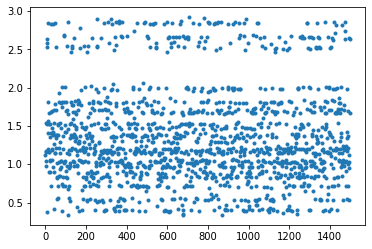

In [117]:
plt.plot(y_pred,".")

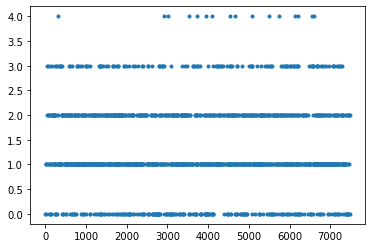

In [118]:
plt.plot(y_test,".")